## tsai Model Development with InceptionTime

https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb


https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb

In [1]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Linux-6.2.0-34-generic-x86_64-with-glibc2.35
python          : 3.9.16
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1
cpu cores       : 6
threads per cpu : 2
RAM             : 62.44 GB
GPU memory      : [3.82] GB


## Data preparation

In [2]:

import os
import pandas as pd
import numpy as np
from io import StringIO
from scipy.stats import mode  # Import the mode function from scipy.stats

# Read the list of unique patient IDs
dir_path = '//home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/03_dataset/'

## Read tarining set
# filename_tr = os.path.join(dir_path, 'zTrainset_raw-0_to_15_ts.csv')
filename_tr = os.path.join(dir_path, 'zzTrainset-0_to_15_ts.csv')
df_tr = pd.read_csv(filename_tr, sep=',', header=0)
display(df_tr)


## Read validation set
# filename_Va = os.path.join(dir_path, 'zValidset_raw-0_to_15_ts.csv')
filename_Va = os.path.join(dir_path, 'zzValidset-0_to_15_ts.csv')
df_Va = pd.read_csv(filename_Va, sep=',', header=0)
display(df_Va)

,patient_id,lab_parameter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,1000010,ALAT,86.000000,-1.00,-1.000000,74.000000,54.000000,-1.00,40.000000,-1.00,-1.000,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,0
1,1000010,ASAT,-1.000000,-1.00,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,-1.000,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,0
2,1000010,Basophile,0.000000,-1.00,-1.000000,0.000000,-1.000000,-1.00,-1.000000,-1.00,-1.000,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,0
3,1000010,Bicarbonat Std.,36.300000,31.02,26.811111,25.628571,26.116667,25.20,24.383333,25.38,26.560,26.625,25.766667,24.82,24.233333,24.45,24.4,25.325,0
4,1000010,Bicarbonat akt.,38.571429,34.30,29.111111,28.028571,25.800000,25.05,23.583333,24.94,27.460,26.500,25.500000,24.56,24.266667,24.80,24.4,25.450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645,1001355,Thrombozyten,181.000000,-1.00,-1.000000,210.000000,-1.000000,-1.00,288.000000,-1.00,-1.000,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,1
6646,1001355,aPTT,35.400000,-1.00,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,-1.000,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,1
6647,1001355,eGFR nach CKD-EPI,71.000000,-1.00,-1.000000,89.000000,-1.000000,-1.00,93.000000,-1.00,-1.000,-1.000,96.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,1
6648,1001355,pH,7.506000,-1.00,7.550500,-1.000000,-1.000000,-1.00,-1.000000,-1.00,7.518,-1.000,-1.000000,-1.00,-1.000000,-1.00,-1.0,-1.000,1


,patient_id,lab_parameter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,1000592,ALAT,20.000000,-1.000000,24.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,1000592,ASAT,30.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,1000592,Basophile,0.015000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3,1000592,Bicarbonat Std.,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
4,1000592,Bicarbonat akt.,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,1001065,Thrombozyten,87.000000,113.000000,85.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
731,1001065,aPTT,38.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
732,1001065,eGFR nach CKD-EPI,117.000000,109.000000,111.00000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
733,1001065,pH,7.390167,7.442571,7.42975,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


#### Practical Deep Learning for Time Series using fastai/ Pytorch: Part 1

https://mohcinemadkour.github.io/posts/2019/10/Machine%20Learning,%20timeseriesAI,%20Time%20Series%20Classification,%20fastai_timeseries/

### Convert dataframe to tensors

In [3]:

# def get_tensor(df, sample_col, feat_col, data_cols, y_func=None):
def get_tensor(df):
    def y_func(o): return mode(o, axis=1, keepdims=True).mode
    # X, y = df2xy(df, sample_col='patient_id', feat_col='lab_parameter', target_col=['target'], data_cols=['0', '1', '2', '3', '4', '5', '6', '7'], y_func=y_func)
    X, y = df2xy(df, sample_col='patient_id', feat_col='lab_parameter', target_col=['target'], data_cols=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'], y_func=y_func)
    print(X.shape, y.shape)
    return X, y


## Get the tensors from the training set
X_tr, y_tr = get_tensor(df_tr)

## Get the tensors from the validation set
X_va, y_va = get_tensor(df_Va)


##
X, y, splits = combine_split_data([X_tr, X_va], [y_tr, y_va])

(190, 35, 16) (190,)
(21, 35, 16) (21,)


In [4]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# dsets = TSDatasets(X, y, tfms=tfms, inplace=True)
display(dsets)

(#211) [(TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0))] ...]

In [5]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)

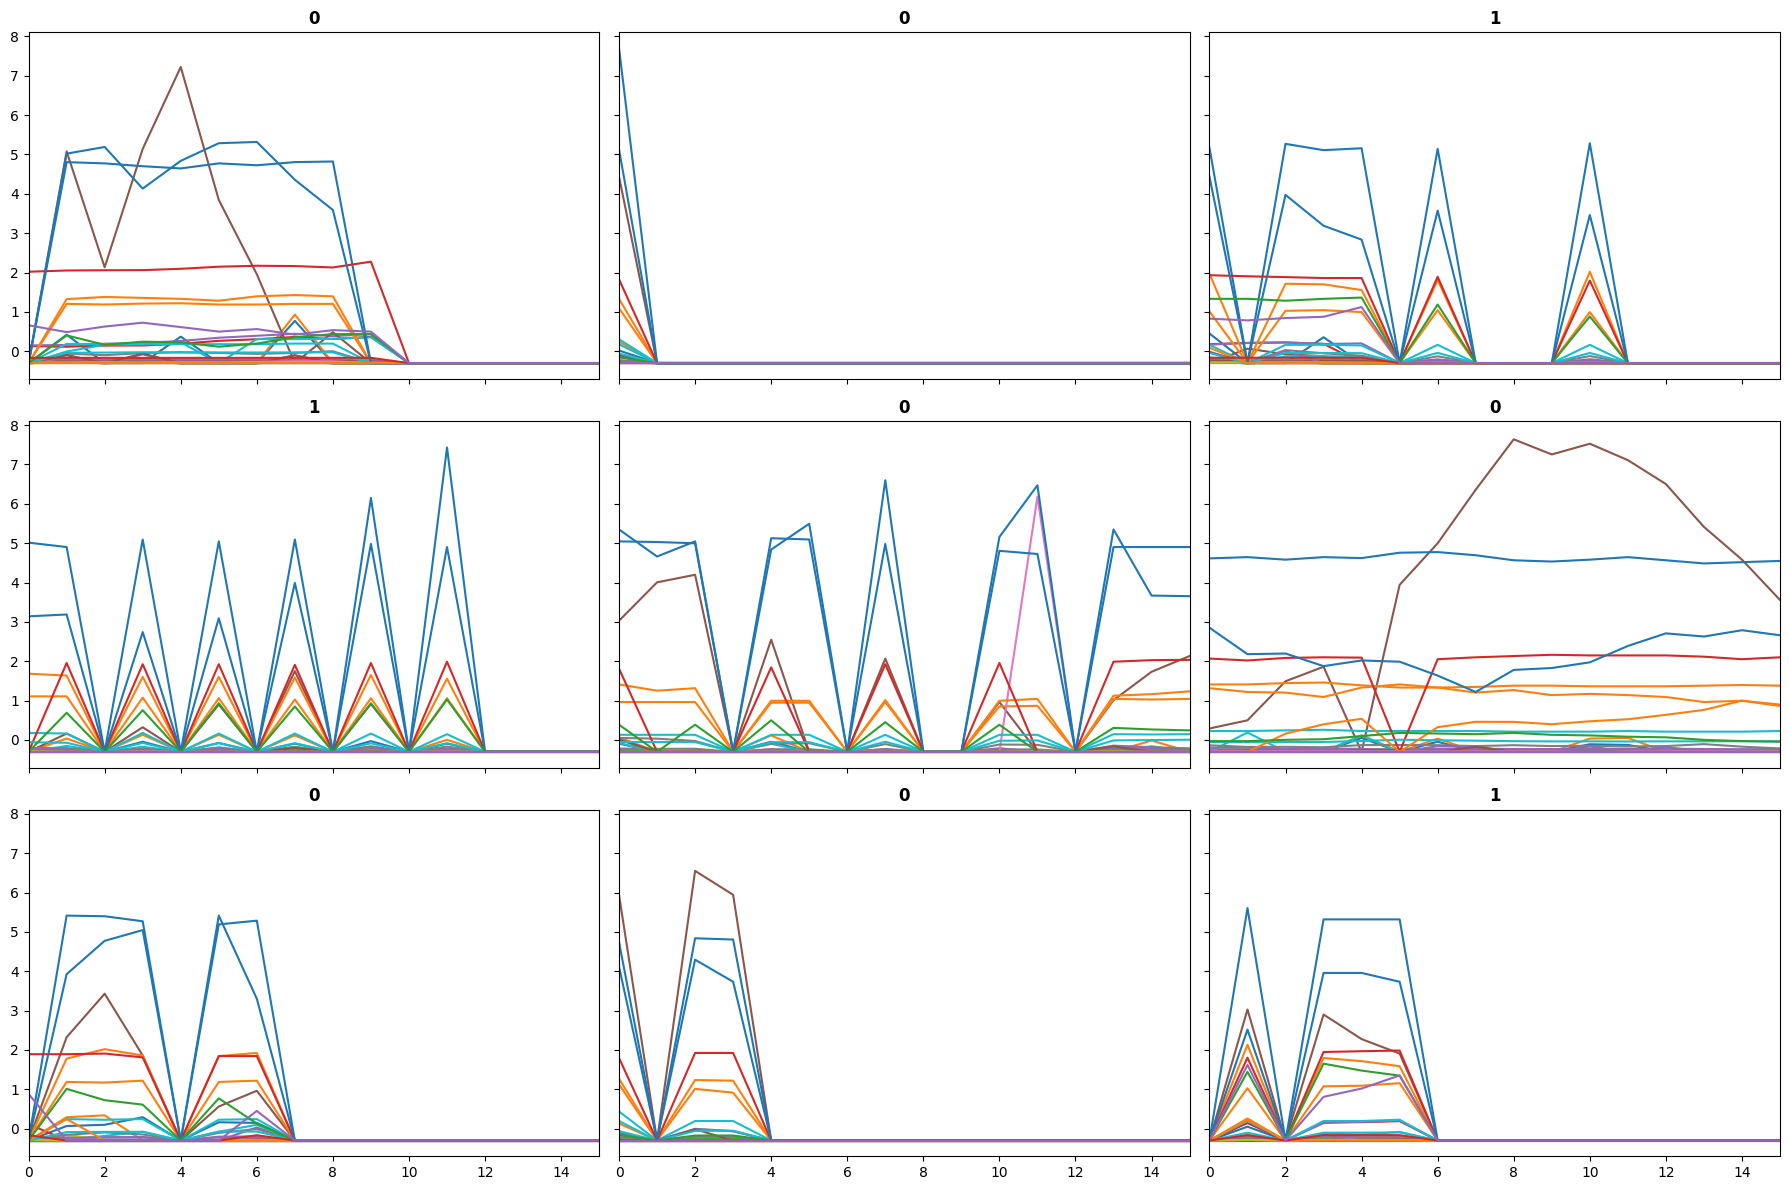

In [7]:
# dls.show_batch(sharey=True)

## Add ledgend to the dls.show_batch
dls.show_batch(sharey=True)

In [8]:
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

SuggestedLRs(valley=0.001737800776027143)

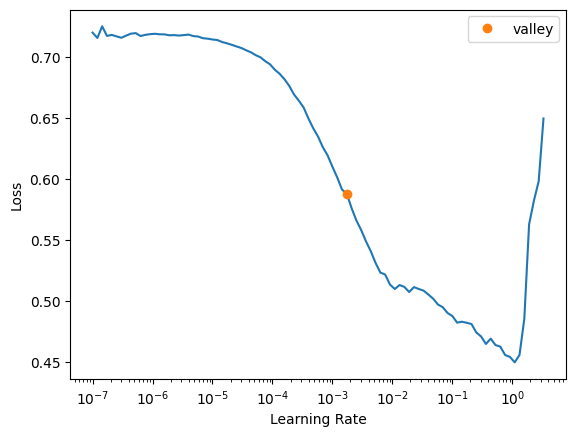

In [9]:
learn.load('stage0')
learn.lr_find()

In [21]:
learn.fit_one_cycle(100, lr_max=1e-3)
learn.save('stage1')
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.000455,0.948509,0.714286,00:03
1,0.000637,0.940838,0.714286,00:02
2,0.000613,0.945931,0.714286,00:02
3,0.000595,0.953324,0.714286,00:02
4,0.000557,0.949312,0.714286,00:02
5,0.000560,0.945292,0.714286,00:03
6,0.000536,0.922430,0.714286,00:03
7,0.000561,0.906771,0.714286,00:04
8,0.000823,0.725104,0.761905,00:04
9,0.000876,0.776370,0.809524,00:03


AttributeError: 'InceptionTime' object has no attribute 'values'

In [ ]:
learn.recorder.plot_metrics()

### To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status:

In [11]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [ ]:
## As soon as we've done this, we can end the session, and continue at any time in the future.
## Let's simulate that we need to end the session now:
del learn, dsets, dls

In [13]:
## Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:21, vars:35, len:16, device=cpu, dtype=torch.float32),
 TensorCategory([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [14]:

valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[7.0916e-04, 9.9929e-01],
         [8.7521e-01, 1.2479e-01],
         [3.5278e-02, 9.6472e-01],
         [9.9332e-01, 6.6836e-03],
         [5.6664e-04, 9.9943e-01],
         [9.0203e-01, 9.7968e-02],
         [1.4834e-02, 9.8517e-01],
         [9.9636e-01, 3.6375e-03],
         [8.3548e-02, 9.1645e-01],
         [9.9949e-01, 5.0920e-04],
         [7.1283e-01, 2.8717e-01],
         [1.3292e-01, 8.6708e-01],
         [7.5102e-01, 2.4898e-01],
         [9.9992e-01, 7.7750e-05],
         [9.1825e-01, 8.1748e-02],
         [9.9992e-01, 8.3980e-05],
         [9.9984e-01, 1.5866e-04],
         [9.9747e-01, 2.5317e-03],
         [9.9013e-01, 9.8699e-03],
         [7.9190e-01, 2.0810e-01],
         [1.8118e-01, 8.1882e-01]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [15]:
(valid_targets == valid_preds).float().mean()

tensor(0.7143)

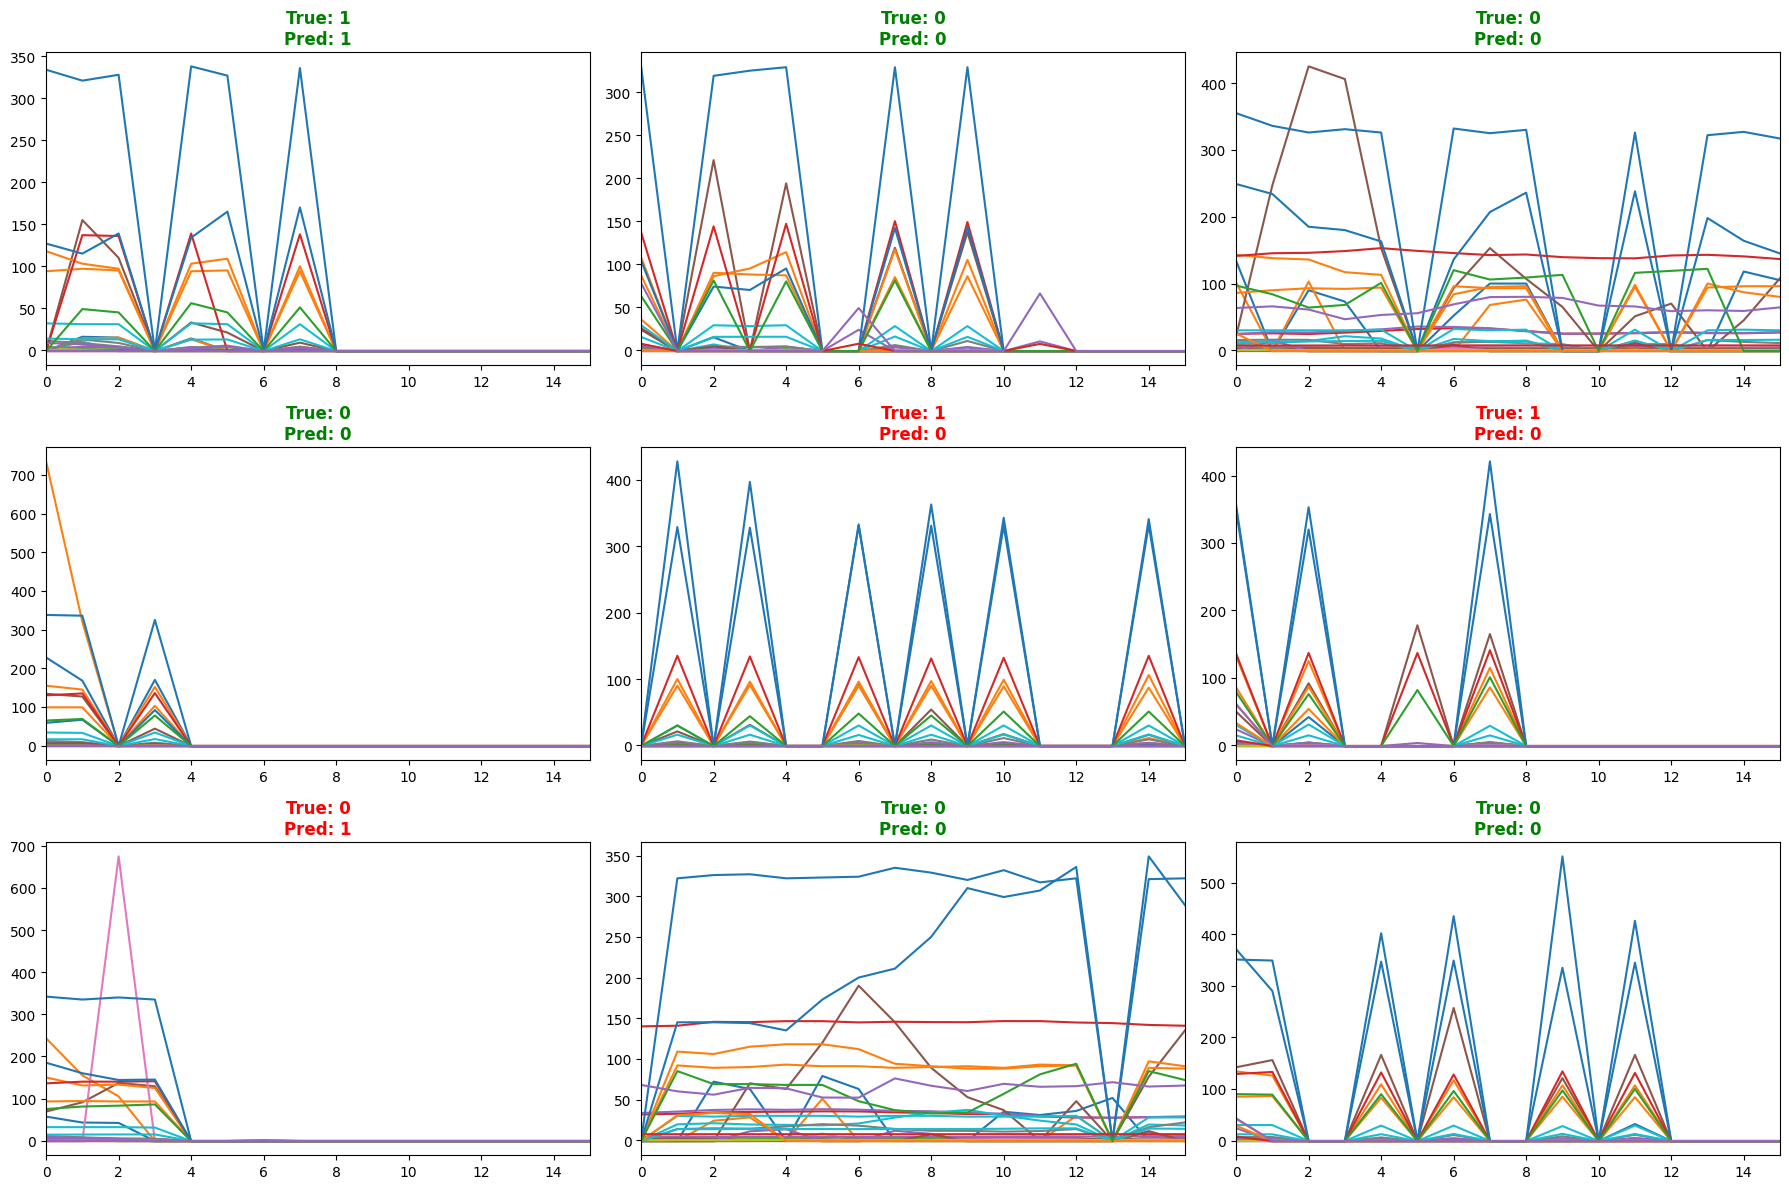

In [20]:
learn.show_results()

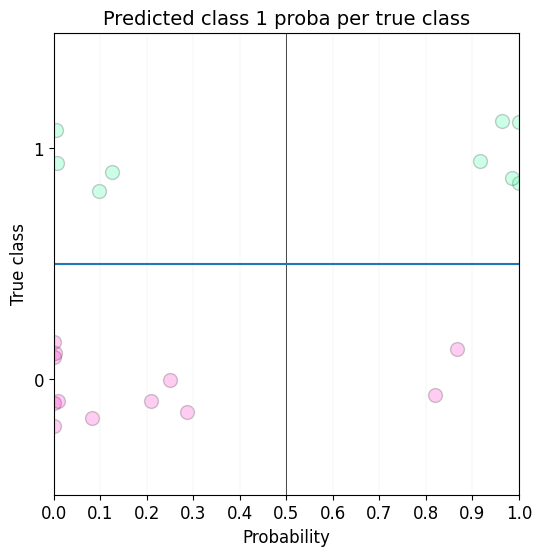

In [18]:
learn.show_probas()

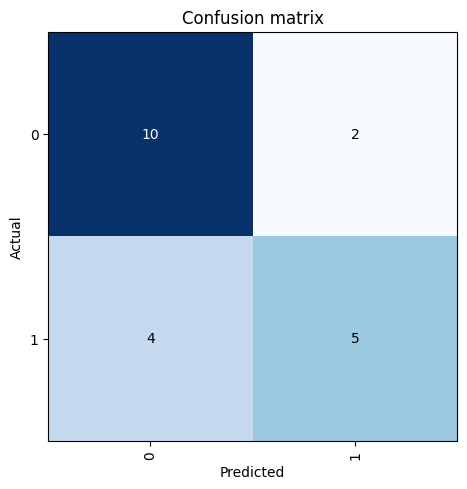

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
     


### Define splits

Transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

- 803 input samples, with 7 features and 104 historical time steps
- 803 input samples, with 7 features and 60 future time steps.

In [ ]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

### Apply a sliding window

- Here is approached the time series forecasting task as a supervised learning problem. 
- tsai requires that both inputs and outputs have the following shape:
    - [# samples x #features #steps]
- To get those inputs and outputs we're going to use a function called prepare_forecasting_data that applies a sliding window along the dataframe.
To use prepare_forecasting_data we need to define some settings

In [ ]:
x_vars = df.columns[2:-1]
y_vars = df.columns[-1:]

display(x_vars)
display(y_vars)

In [ ]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape